# Classification
In this notebook, we will apply several classification algorithms on two data set: *Iris* and *Digits*. The first one is a low dimensional data set while the second one contains more features.

In [1]:
from sklearn.datasets import load_digits, load_iris
# Load digits
X, y = load_digits(return_X_y=True) # load_iris(return_X_y=True)
print(X.shape)

(1797, 64)


## Classification pipeline
Two steps are required
- Model selection, i.e. find the optimal hyperparemeters,
- Model assessement, i.e. validate the model on unseen data.

As said in introduction, scikit-learn offers convenient and generic functions to achieve these steps. In what follow, an example is given for SVM. But it can be extended for any algorithm in scikit-learn, up to a correct definition of the hyperparameters.

In [2]:
import scipy as sp
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Standardize data
sc = MinMaxScaler()
X = sc.fit_transform(X)

# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.20, random_state=0, stratify=y)

With kernel methods (and more generaly for any distance based methods), it is a good practice to standardize feature remove dynamics effect. Here we rescale each feature between 0 and 1.

In [3]:
# Definition of the hyperparameters values search
degree = sp.arange(1,7) # Degree of the polynomial kernel
C = 10.0**sp.arange(0,4)
param_grid_svm = dict(degree=degree, C=C, kernel=['poly'])

We use [cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html) strategy to select the optimal set of hyperparameters.

In [4]:
grid = GridSearchCV(SVC(),  # Set up the classifier
                    param_grid=param_grid_svm, 
                    cv= 5,
                    n_jobs=-1) # Do the grid search in parallel
grid.fit(X_train, y_train) # Run the grid search
print("Best score: {}".format(grid.best_score_))
print("Best set of hyperparameters: {}".format(grid.best_params_))
print
# Learn the optimal model
clf = grid.best_estimator_  # Get the best estimator
clf.fit(X_train,y_train)

# Predict new samples
y_pred = clf.predict(X_test)

# Compute the overall accuracies
print(accuracy_score(y_test,y_pred))

Best score: 0.9693593314763231
Best set of hyperparameters: {'C': 1000.0, 'degree': 3, 'kernel': 'poly'}
0.969401947149


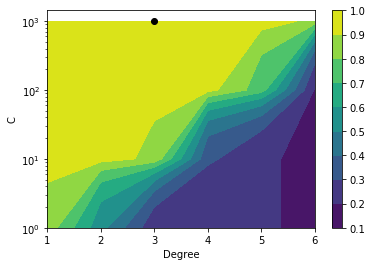

In [5]:
res = grid.cv_results_['mean_test_score'].reshape(C.size,degree.size)
%matplotlib inline
import matplotlib.pyplot as plt
X, Y = sp.meshgrid(degree, C)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
cp = ax.contourf(X, Y, res)
ax.scatter(grid.best_params_['degree'],grid.best_params_['C'],color='k')
ax.set_yscale("log")
ax.set_xlabel("Degree")
ax.set_ylabel("C")
fig.colorbar(cp)

Now suppose we would like to compare several kernels. We need can use the same workflow, just by adding one line and modifying one line !!

In [6]:
gamma = 2.0**sp.arange(-4,2) # Scale of the RBF kernel

In [7]:
param_grid_svm = [dict(kernel=['rbf'],gamma=gamma, C=C),
                  dict(kernel=['poly'],degree=degree, C=C)]

We can now now copy/past/run the same code than previously:

In [8]:
grid = GridSearchCV(SVC(),  # Set up the classifier
                    param_grid=param_grid_svm, 
                    cv= 5,
                    n_jobs=-1) # Do the grid search in parallel
grid.fit(X_train, y_train) # Run the grid search
print("Best score: {}".format(grid.best_score_))
print("Best set of hyperparameters: {}".format(grid.best_params_))
print
# Learn the optimal model
clf = grid.best_estimator_  # Get the best estimator
clf.fit(X_train,y_train)

# Predict new samples
y_pred = clf.predict(X_test)

# Compute the overall accuracies
print(accuracy_score(y_test,y_pred))

Best score: 0.9721448467966574
Best set of hyperparameters: {'C': 10.0, 'gamma': 0.125, 'kernel': 'rbf'}
0.972183588317


## Comparison of the differents classifiers
In the course, we have discussed about three classifiers: QDA, SVM and K-NN. Using the following scripts, we are going to compare their performances on the given data sets. Again, using scikit-learn generic function, it is possible we few lines of code to run all the experiments.


In [9]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Define the classifier list
classifiers = [SVC(), KNeighborsClassifier(), QuadraticDiscriminantAnalysis()]
names = ["SVM", "KNN", "QDA"]

# Define the dictionnary of parameters to optimize
param_grids = [dict(kernel=['rbf'], gamma=gamma, C=C),
               dict(n_neighbors = sp.arange(1,40)), # number of neighbors for KNN
               dict(reg_param = sp.linspace(0,0.1,30)), # Regularization parameter for QDA
               ]

# Run LDA (no hyperparameters to tune)
clf = LinearDiscriminantAnalysis()
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print("Classification accuracy for {}: {}".format("LDA",accuracy_score(y_test,y_pred)))
    
# Run all classifiers
for classifier, name, param_grid in zip(classifiers, names, param_grids):
    grid = GridSearchCV(classifier, param_grid=param_grid, cv= 5, n_jobs=-1)
    grid.fit(X_train, y_train)
    
    clf = grid.best_estimator_ 
    clf.fit(X_train,y_train)
    
    y_pred = clf.predict(X_test)
    print("Classification accuracy for {}: {} (best parameters {})".format(name,accuracy_score(y_test,y_pred),grid.best_params_))

Classification accuracy for LDA: 0.9297635605006954
Classification accuracy for SVM: 0.972183588317107 (best parameters {'C': 10.0, 'gamma': 0.125, 'kernel': 'rbf'})
Classification accuracy for KNN: 0.9617524339360223 (best parameters {'n_neighbors': 1})
Classification accuracy for QDA: 0.9652294853963839 (best parameters {'reg_param': 0.010344827586206898})


## Pipeline
In the previous section, we have selected the best kernel from the polynomial and RBF one. But it is also possible to combine them using [pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline) facility offer by scikit-learn. The following code does the job. To make it simple we select the best set of hyperparameters from the previous individual cross-validation. However, it is possible to search for the best combination (if we have a lot of time ...).

We first define the CompositeKernel class, which is the weighted summation of the RBF and polynomial kernel.

In [10]:
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

# Convenient Class for summation kernel
class CompositeKernel(BaseEstimator,TransformerMixin):
    def __init__(self,
                 mu=0.5,
                 gamma=0.125,  
                 degree=3):
        self.gamma = gamma
        self.degree = degree
        self.mu = mu
        
    def transform(self,X):
        K = self.mu*rbf_kernel(X,self.X_,gamma=self.gamma)
        K += (1-self.mu)*polynomial_kernel(X,self.X_,degree=self.degree)
        return K

    def fit(self,X,y=None, **fit_params):
        self.X_ = X
        return self

Then we define the pipeline:

In [11]:
# Create a pipeline
pipe = Pipeline([
    ('CK',CompositeKernel()),
    ('SVM',SVC())
])

Then we define the range search for the weight paramter *mu* (note that here we do not optimize the parameter of the polynomial and RBF kernels)

In [13]:
param_grid = dict([
    ('CK__mu', sp.linspace(0,1,num=11)),  # Note the double "_" to define parameters of a pipeline
    ('CK__gamma', gamma),
    ('CK__degree', degree),
    ('SVM__C',C),
    ('SVM__kernel', ['precomputed']),
])
grid = GridSearchCV(pipe,  # Set up the classifier -> Here we put our pipeline
                    param_grid=param_grid, 
                    cv= 5,
                    n_jobs=-1) # Do the grid search in parallel
grid.fit(X_train, y_train) # Run the grid search and wait: 11*6*6*4 tuples of values to be tested !
print("Best score: {}".format(grid.best_score_))
print("Best set of hyperparameters: {}".format(grid.best_params_))
print
# Learn the optimal model
clf = grid.best_estimator_  # Get the best estimator
clf.fit(X_train,y_train)

# Predict new samples
y_pred = clf.predict(X_test)

# Compute the overall accuracies
print(accuracy_score(y_test,y_pred))

Best score: 0.9749303621169917
Best set of hyperparameters: {'CK__gamma': 0.25, 'CK__degree': 6, 'CK__mu': 0.30000000000000004, 'SVM__kernel': 'precomputed', 'SVM__C': 1.0}
0.96314325452
